In [1]:
import optuna
import numpy as np
from functools import partial
from tensorflow.keras.datasets import mnist
from tensorflow.compat.v1.keras import callbacks, backend, layers, optimizers, Model, Input

In [2]:
def load_mnist_data():
    (train_x, train_y), (test_x, test_y) = mnist.load_data()
    # Make sure images have shape (28, 28, 1)
    train_x = np.expand_dims(train_x, axis=-1)
    test_x = np.expand_dims(test_x, axis=-1)
    # Scale images to the [0, 1] range
    train_x = train_x.astype("float32")/255.0
    test_x = test_x.astype("float32")/255.0
    # Reshape labels
    train_y = train_y.reshape(-1, 1)
    test_y = test_y.reshape(-1, 1)
    print(f"# Train data shape: {train_x.shape}")
    print(f"# Train label shape: {train_y.shape}")
    return (train_x, train_y), (test_x, test_y)

In [3]:
def get_model(input_shape, output_size, layer_sizes, kernel_regularizer="l2", dropout_rate=0.2, opt="adam"):
    img_input = Input(shape=input_shape, name="img_input")
    x = layers.Conv2D(filters=32, kernel_size=5)(img_input)
    x = layers.MaxPool2D(pool_size=3)(x)
    x = layers.Conv2D(filters=32, kernel_size=3)(x)
    x = layers.Flatten()(x)
    outputs = []
    for size in layer_sizes:
        x = layers.Dense(size, activation="relu", kernel_regularizer=kernel_regularizer)(x)
        x = layers.Dropout(dropout_rate)(x)
        outputs.append(x)
    x = layers.Concatenate()(outputs)
    
    # x = networks.concated_dense(x, num_layers, layer_size, activation="relu", kernel_regularizer=kernel_regularizer, dropout_rate=dropout_rate)
    x = layers.Dense(0.5*sum(layer_sizes), activation="relu", kernel_regularizer="l2")(x)
    prob_out = layers.Dense(output_size, activation="softmax", name="prob_output")(x)
    model = Model(inputs=[img_input], outputs=[prob_out], name="classifier")
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])
    return model

In [4]:
def scheduler(epoch, const_till=10, lr=1e-3, min_lr=None, decay_rate=0.1):
    """
    Learning rate scheduler function
    """
    if min_lr is None:
        min_lr = 0.2*lr
    if epoch < const_till:
        return lr
    else:
        return max(min_lr, lr*np.math.exp(decay_rate*(const_till - epoch)))

## Load MNIST data

In [5]:
(train_x, train_y), (test_x, test_y) = load_mnist_data()

# Train data shape: (60000, 28, 28, 1)
# Train label shape: (60000, 1)


## Optimize model

In [14]:
# def optimize(params, *, epochs, input_shape, output_size):
def objective(trial):
    # Constant hyperparameters
    epochs = 50
    lr = 3e-3
    batch_size = 256
    input_shape = INPUT_SHAPE
    output_size = OUTPUT_SIZE
    # Tunable hyperparameters
    num_layers = trial.suggest_int("num_layers", 2, 10)
    params = dict(layer_sizes = [trial.suggest_int(f"layer_size_{i}", 5, 80) for i in range(num_layers)],
                  kernel_regularizer = trial.suggest_categorical("kernel_regularizer", [None, "l1", "l2"]),
                  dropout_rate = trial.suggest_loguniform("dropout_rate", 0.1, 0.5))
    backend.clear_session()
    lr_func = partial(scheduler, lr=lr, min_lr=3e-5, const_till=10, decay_rate=0.1)
    lr_callback = callbacks.LearningRateScheduler(lr_func)
    classifier = get_model(input_shape=input_shape, output_size=output_size, opt=optimizers.Adam(lr=lr), **params)
    history = classifier.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[lr_callback], verbose=0)
    loss, acc = classifier.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
    return acc

params = dict(layer_size=hp.randint("layer_size", 5, 80), 
              num_layers=hp.randint("num_layers", 3, 9), 
              kernel_regularizer=hp.choice("kernel_regularizer", [None, "l2"]), 
              dropout_rate=hp.uniform("dropout_rate", 0.1, 0.5))

In [15]:
INPUT_SHAPE = train_x[0].shape
OUTPUT_SIZE = len(set(test_y.squeeze()))
sampler = None # optuna.samplers.TPESampler(multivariate=True)
study_name = "mnist_hyperopt"
study = optuna.create_study(direction="maximize", storage="sqlite:///mnist_gan.db", study_name=study_name, load_if_exists=True, sampler=sampler)

[I 2021-01-05 19:03:07,025] Using an existing study with name 'mnist_hyperopt' instead of creating a new one.


In [16]:
%%time
study.optimize(objective, n_trials=50, show_progress_bar=True)

/home/rajk/miniconda3/envs/gan-env/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2021-01-05 19:04:19,213] Trial 51 finished with value: 0.9912999868392944 and parameters: {'num_layers': 4, 'layer_size_0': 44, 'layer_size_1': 68, 'layer_size_2': 76, 'layer_size_3': 21, 'kernel_regularizer': None, 'dropout_rate': 0.18864217405743133}. Best is trial 37 with value: 0.9937000274658203.
[I 2021-01-05 19:05:29,039] Trial 52 finished with value: 0.9923999905586243 and parameters: {'num_layers': 6, 'layer_size_0': 70, 'layer_size_1': 61, 'layer_size_2': 56, 'layer_size_3': 14, 'layer_size_4': 56, 'layer_size_5': 10, 'kernel_regularizer': None, 'dropout_rate': 0.20036055277282122}. Best is trial 37 with value: 0.9937000274658203.
[I 2021-01-05 19:06:35,487] Trial 53 finished with value: 0.9930999875068665 and parameters: {'num_layers': 4, 'layer_size_0': 75, 'layer_size_1': 69, 'layer_size_2': 70, 'layer_size_3': 9, 'kernel_regularizer': None, 'dropout_rate': 0.1307467065803978}. Best is trial 37 with value: 0.9937000274658203.
[I 2021-01-05 19:07:41,832] Trial 54 finishe

In [17]:
study.best_params

{'dropout_rate': 0.16204718254121872,
 'kernel_regularizer': None,
 'layer_size_0': 73,
 'layer_size_1': 67,
 'layer_size_2': 80,
 'layer_size_3': 40,
 'layer_size_4': 52,
 'layer_size_5': 16,
 'layer_size_6': 60,
 'layer_size_7': 26,
 'layer_size_8': 44,
 'num_layers': 9}

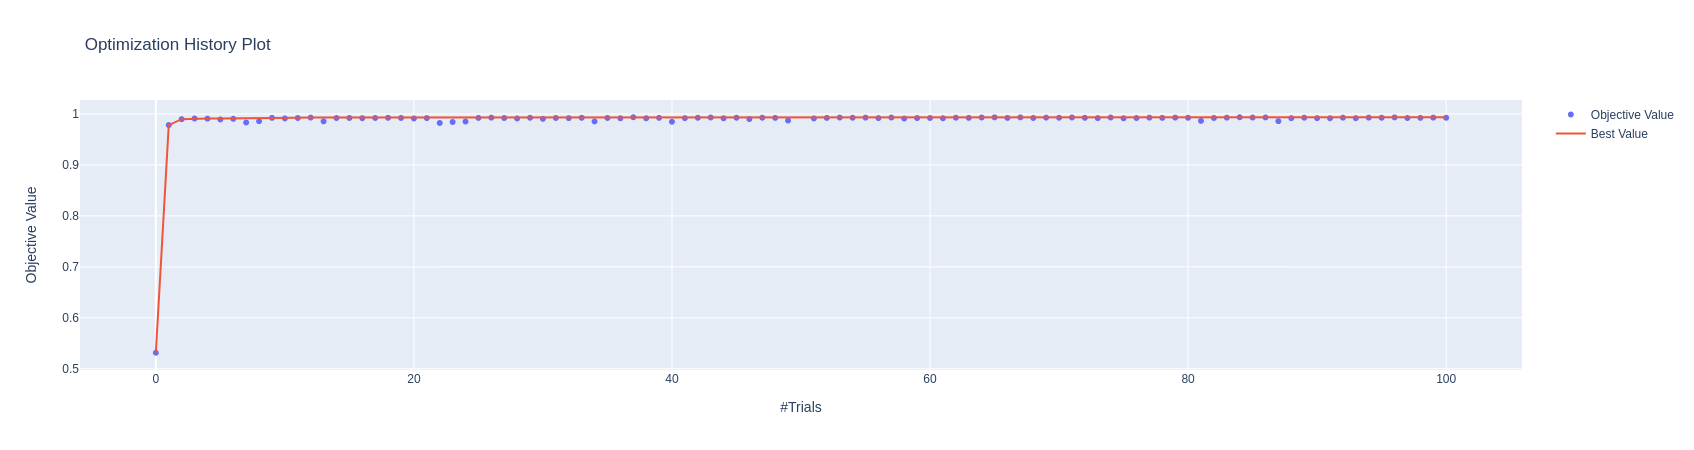

In [18]:
optuna.visualization.plot_optimization_history(study)

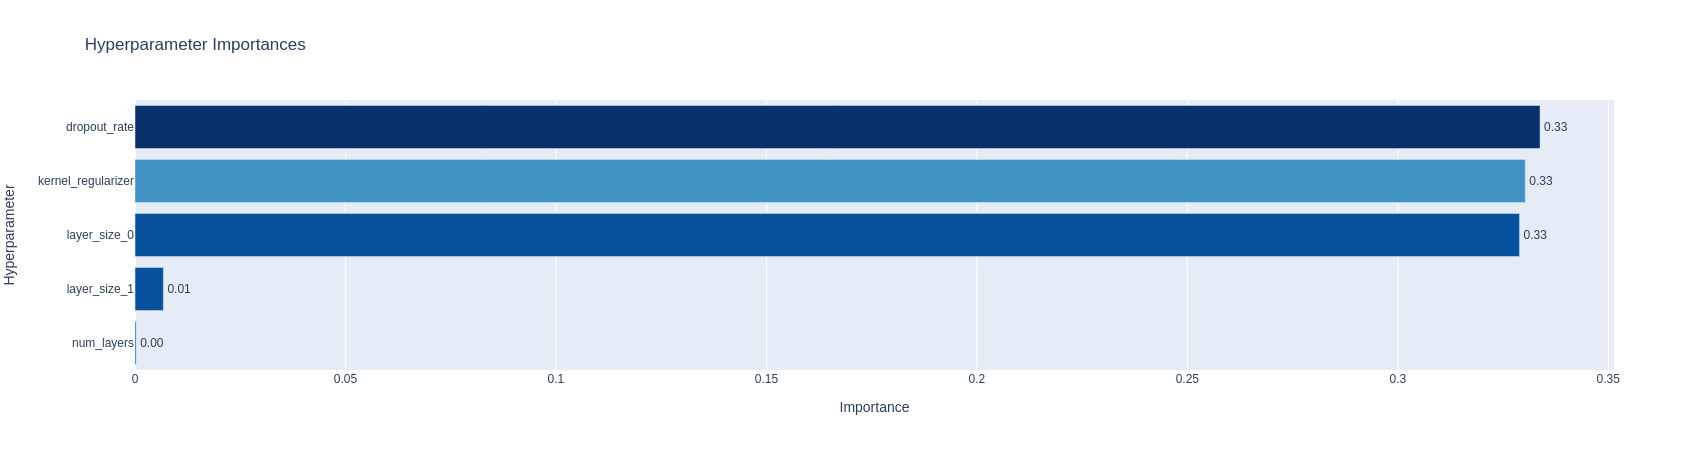

In [19]:
optuna.visualization.plot_param_importances(study)

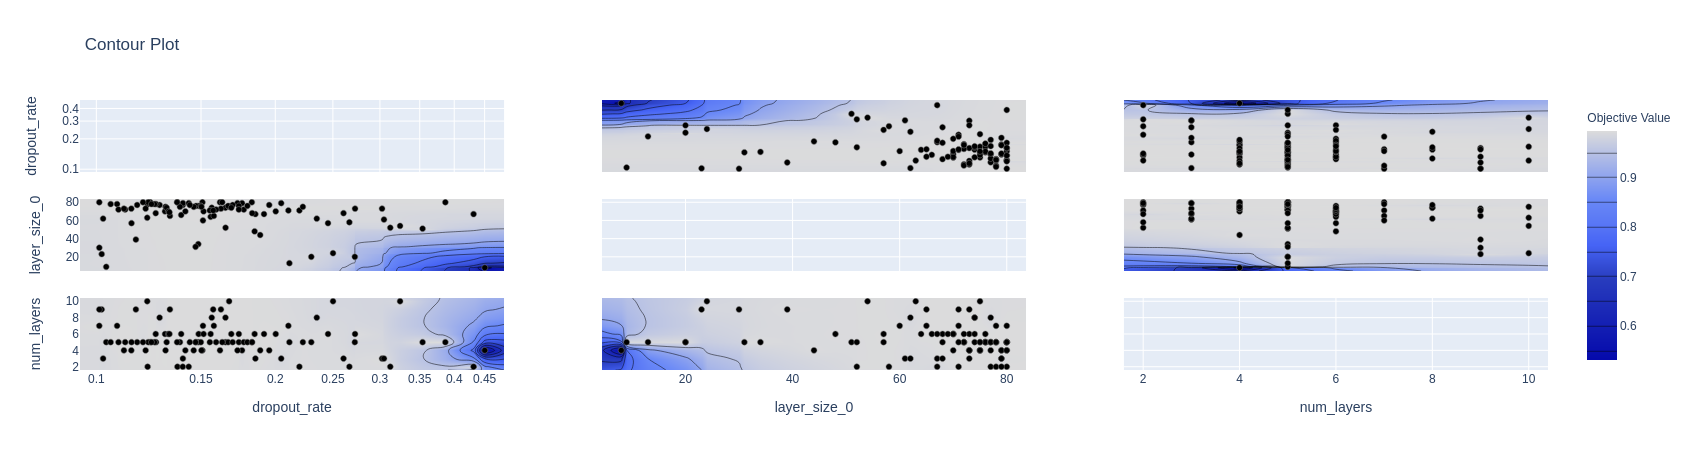

In [20]:
optuna.visualization.plot_contour(study, params=["num_layers", "dropout_rate", "layer_size_0"])

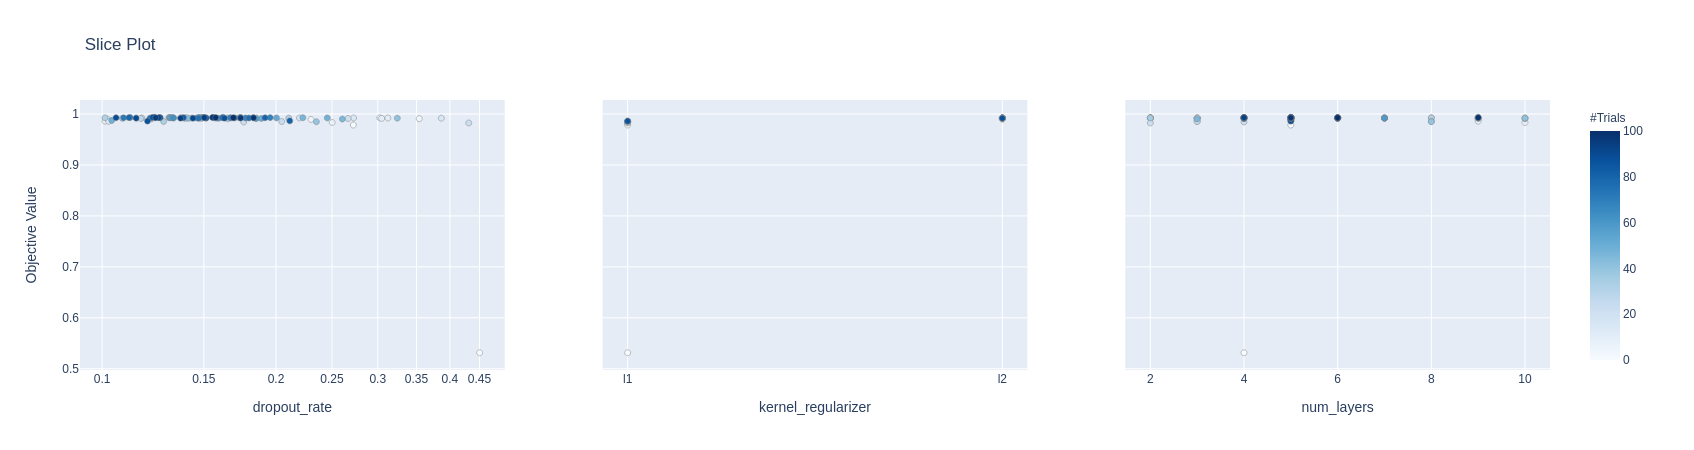

In [21]:
optuna.visualization.plot_slice(study, params=["num_layers", "dropout_rate", "kernel_regularizer"])